## Mean Encoding

- log transformation 대신 쓸 수 있는 다른 encoding 기법
- log transformation은 Numeric data에 사용하는 것인데, mean encoding은 one-hot encoding처럼 Category 데이터에 사용할 수 있음
- Category 데이터에는 항상 One-hot Encoding 하는 것이 아님. 다양한 인코딩 기법들이 존재함
- 대표적인 방법으로 Y값에 대한 분포를 확인하는 Mean encoding이 있음
- 분포의 값을 취해서 one-hot encoding 처럼 넣어주는 것
- 조금 더 빠르게, 조금 더 나은 성능이 나올 수 있음
- Overfitting을 제거하기 위해서 smoothing을 사용하기도 함

## Mean encoding을 사용하는 이유

- 분포는 분명 카테고리별로 y의 값과 상관관계가 있을 것임.
- 하지만 단순하게 0, 또는 1로만 표현하면 상관관계에 대한 정보가 loss 될 수 있음.
- 상관관계에 대한 것을 반영하기 위해서 사용
- 각 레이블이 예측 결과에 미치는 영향을 반영하면서도, 차원을 늘리지 않고 모델의 성능을 향상시킬 수 있음.

## Mean encoding apply - titanic

- 예를 들어, 타이타닉에서 (Pclass) 별로 생존한 비율이 다름. 이 비율 값을 transformation으로 넣어주는 것.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
DATA_DIR = './titanic'
data_files = reversed([os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)])
df_list = []
for filename in data_files:
    df_list.append(pd.read_csv(filename))
df = pd.concat(df_list, sort=False)
df = df.reset_index(drop=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [3]:
number_of_train_dataset = df['Survived'].notnull().sum()  # train data의 개수
number_of_test_dataset = df['Survived'].isnull().sum()  # test data의 개수
y_true = df.pop('Survived')[:number_of_train_dataset]  # train data까지 슬라이싱

In [4]:
df.loc[61, 'Embarked'] = 'S'
df.loc[829, 'Embarked'] = 'S'

In [5]:
def merge_and_get(ldf, rdf, on, how='inner', index=None):
    if index is True:
        return pd.merge(ldf, rdf, how=how, left_index=True, right_index=True)
    else:
        return pd.merge(ldf, rdf, how=how, on=on)

In [6]:
sex_dummies = pd.get_dummies(df[['Sex']])
pclass_dummies = pd.get_dummies(df['Pclass'], prefix='Pclass')
embarked_dummies = pd.get_dummies(df[['Embarked']])

In [7]:
one_hot_df = merge_and_get(df, sex_dummies, on=None, index=True)
one_hot_df = merge_and_get(one_hot_df, pclass_dummies, on=None, index=True)
one_hot_df = merge_and_get(one_hot_df, embarked_dummies, on=None, index=True)

#### 가장 단순한 형태의 mean encoding

- Pclass별 생존의 평균

In [8]:
temp_df = pd.merge(
    one_hot_df['Pclass'], y_true, left_index=True, right_index=True
)
temp_df.groupby('Pclass')["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [9]:
temp_df['Pclass'].replace(
    temp_df.groupby('Pclass')['Survived'].mean()
)

0      0.242363
1      0.629630
2      0.242363
3      0.629630
4      0.242363
         ...   
886    0.472826
887    0.629630
888    0.242363
889    0.629630
890    0.242363
Name: Pclass, Length: 891, dtype: float64

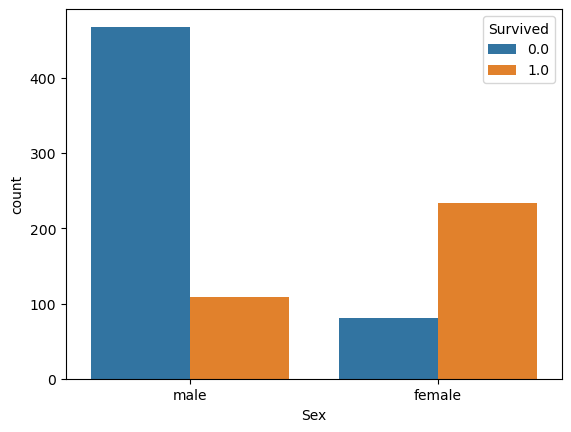

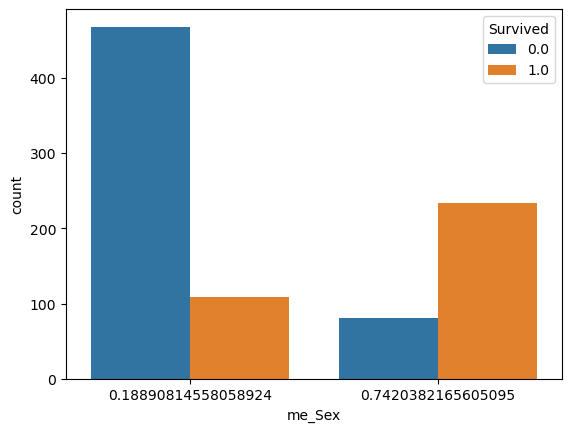

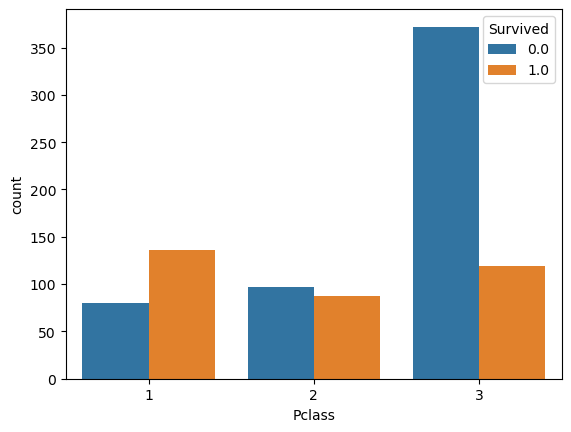

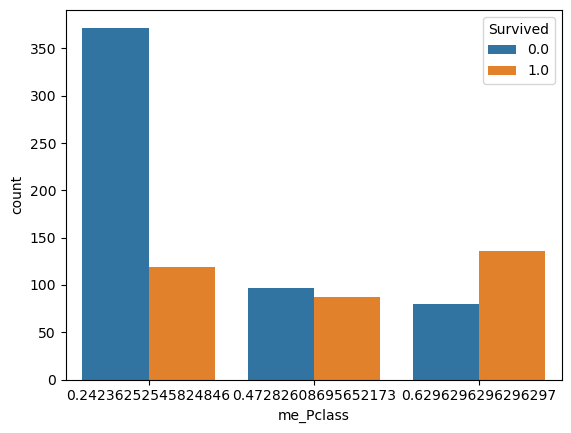

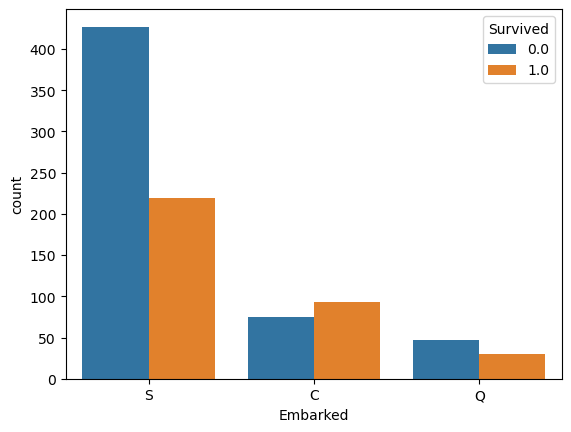

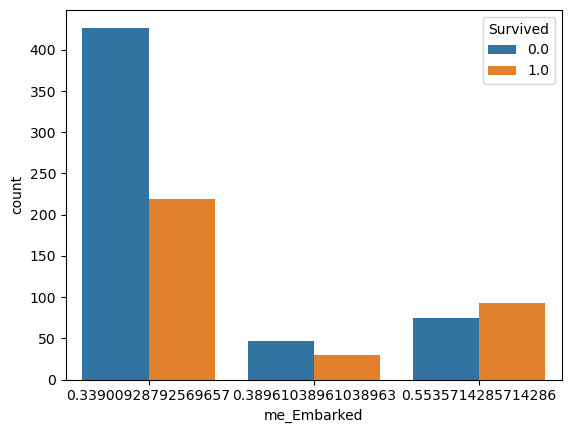

In [14]:
temp_columns = ['Sex', 'Pclass', 'Embarked']

me_list = []
for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index=True, right_index=True)
    temp_df['me_' + col_name] = temp_df[col_name].replace(temp_df.groupby(col_name)['Survived'].mean())
    sns.countplot(x=col_name, hue='Survived', data=temp_df)
    plt.show()
    sns.countplot(x = 'me_' + col_name, hue='Survived', data=temp_df)
    plt.show()
    me_list.append(temp_df.drop('Survived', axis=1))  # me_list에 각각의 mean encoding 값들 저장하기

In [18]:
me_list

[        Sex    me_Sex
 0      male  0.188908
 1    female  0.742038
 2    female  0.742038
 3    female  0.742038
 4      male  0.188908
 ..      ...       ...
 886    male  0.188908
 887  female  0.742038
 888  female  0.742038
 889    male  0.188908
 890    male  0.188908
 
 [891 rows x 2 columns],
      Pclass  me_Pclass
 0         3   0.242363
 1         1   0.629630
 2         3   0.242363
 3         1   0.629630
 4         3   0.242363
 ..      ...        ...
 886       2   0.472826
 887       1   0.629630
 888       3   0.242363
 889       1   0.629630
 890       3   0.242363
 
 [891 rows x 2 columns],
     Embarked  me_Embarked
 0          S     0.339009
 1          C     0.553571
 2          S     0.339009
 3          S     0.339009
 4          S     0.339009
 ..       ...          ...
 886        S     0.339009
 887        S     0.339009
 888        S     0.339009
 889        C     0.553571
 890        Q     0.389610
 
 [891 rows x 2 columns]]

In [22]:
me_columns = pd.concat(me_list, axis=1)[["me_" + col_name for col_name in temp_columns]]
me_columns

,me_Sex,me_Pclass,me_Embarked
0,0.188908,0.242363,0.339009
1,0.742038,0.629630,0.553571
2,0.742038,0.242363,0.339009
3,0.742038,0.629630,0.339009
4,0.188908,0.242363,0.339009
...,...,...,...
886,0.188908,0.472826,0.339009
887,0.742038,0.629630,0.339009
888,0.742038,0.242363,0.339009
889,0.188908,0.629630,0.553571


In [23]:
temp_df = pd.merge(me_columns, y_true, left_index=True, right_index=True)
temp_df

,me_Sex,me_Pclass,me_Embarked,Survived
0,0.188908,0.242363,0.339009,0.0
1,0.742038,0.629630,0.553571,1.0
2,0.742038,0.242363,0.339009,1.0
3,0.742038,0.629630,0.339009,1.0
4,0.188908,0.242363,0.339009,0.0
...,...,...,...,...
886,0.188908,0.472826,0.339009,0.0
887,0.742038,0.629630,0.339009,1.0
888,0.742038,0.242363,0.339009,0.0
889,0.188908,0.629630,0.553571,1.0


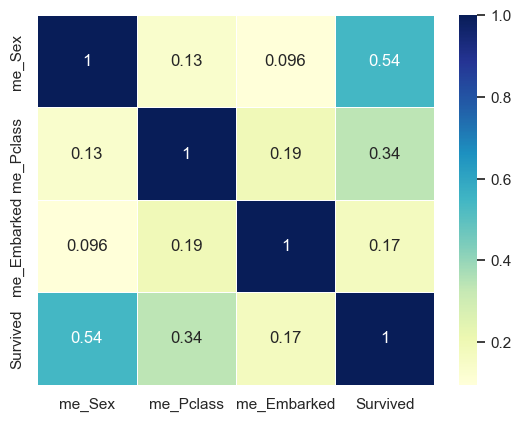

In [24]:
corr = temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot=True, linewidths=0.5, cmap='YlGnBu')

- Mean encoding을 통해서 관계를 더 잘 설명할 수 있음

## Interaction features

- 여러 feature들을 합쳐서 사용하는 것이 interation feature
  - ex) house price를 예측할 때, size만 사용하는 것이 아닌 height 등과 섞어서 사용할 수 있음
- 기존 feature들의 조합으로 새로운 feature를 생성
- Data에 대한 사전 지식과 이해가 필요함
- Polynomial feature를 사용한 자동화 기능 -> 높은 비용
- 실험적으로 접근할 요소들은 있음 -> 자동화
- weight + time-period, sensor1 + sensor2

## Interation features in Titanic

#### Categorical Combination

In [30]:
temp_columns = ['Sex', 'Pclass', 'Embarked']
# Sex와 Pclass 간의 관계를 찾기 위함.
one_hot_df['Sex-Pclass'] = df['Sex'].map(str)+df['Pclass'].map(str)
one_hot_df['Embarked-Pclass'] = df['Embarked'].map(str)+df['Pclass'].map(str)

one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df['Sex-Pclass'], prefix="SexPclass"), on=None, index=True)
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df['Embarked-Pclass'], prefix="EmbarkedPclass"), on=None, index=True)
one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,0,0,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,0,0,0,0,0,0,0,1,0,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,0,1,0,0,0,0,0,0,0,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1


In [33]:
# 체크하고 싶은 column들만 뽑기
crosscheck_columns = [col_name for col_name in one_hot_df.columns.tolist() if col_name.split('_')[0] in ['SexPclass', "EmbarkedPclass"] and "_" in col_name]
crosscheck_columns

['SexPclass_female1',
 'SexPclass_female2',
 'SexPclass_female3',
 'SexPclass_male1',
 'SexPclass_male2',
 'SexPclass_male3',
 'EmbarkedPclass_C1',
 'EmbarkedPclass_C2',
 'EmbarkedPclass_C3',
 'EmbarkedPclass_Q1',
 'EmbarkedPclass_Q2',
 'EmbarkedPclass_Q3',
 'EmbarkedPclass_S1',
 'EmbarkedPclass_S2',
 'EmbarkedPclass_S3']

In [36]:
temp_df = pd.merge(one_hot_df[crosscheck_columns], y_true, left_index=True, right_index=True)
temp_df

,SexPclass_female1,SexPclass_female2,SexPclass_female3,SexPclass_male1,SexPclass_male2,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3,Survived
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0
887,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.0
888,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0
889,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1.0


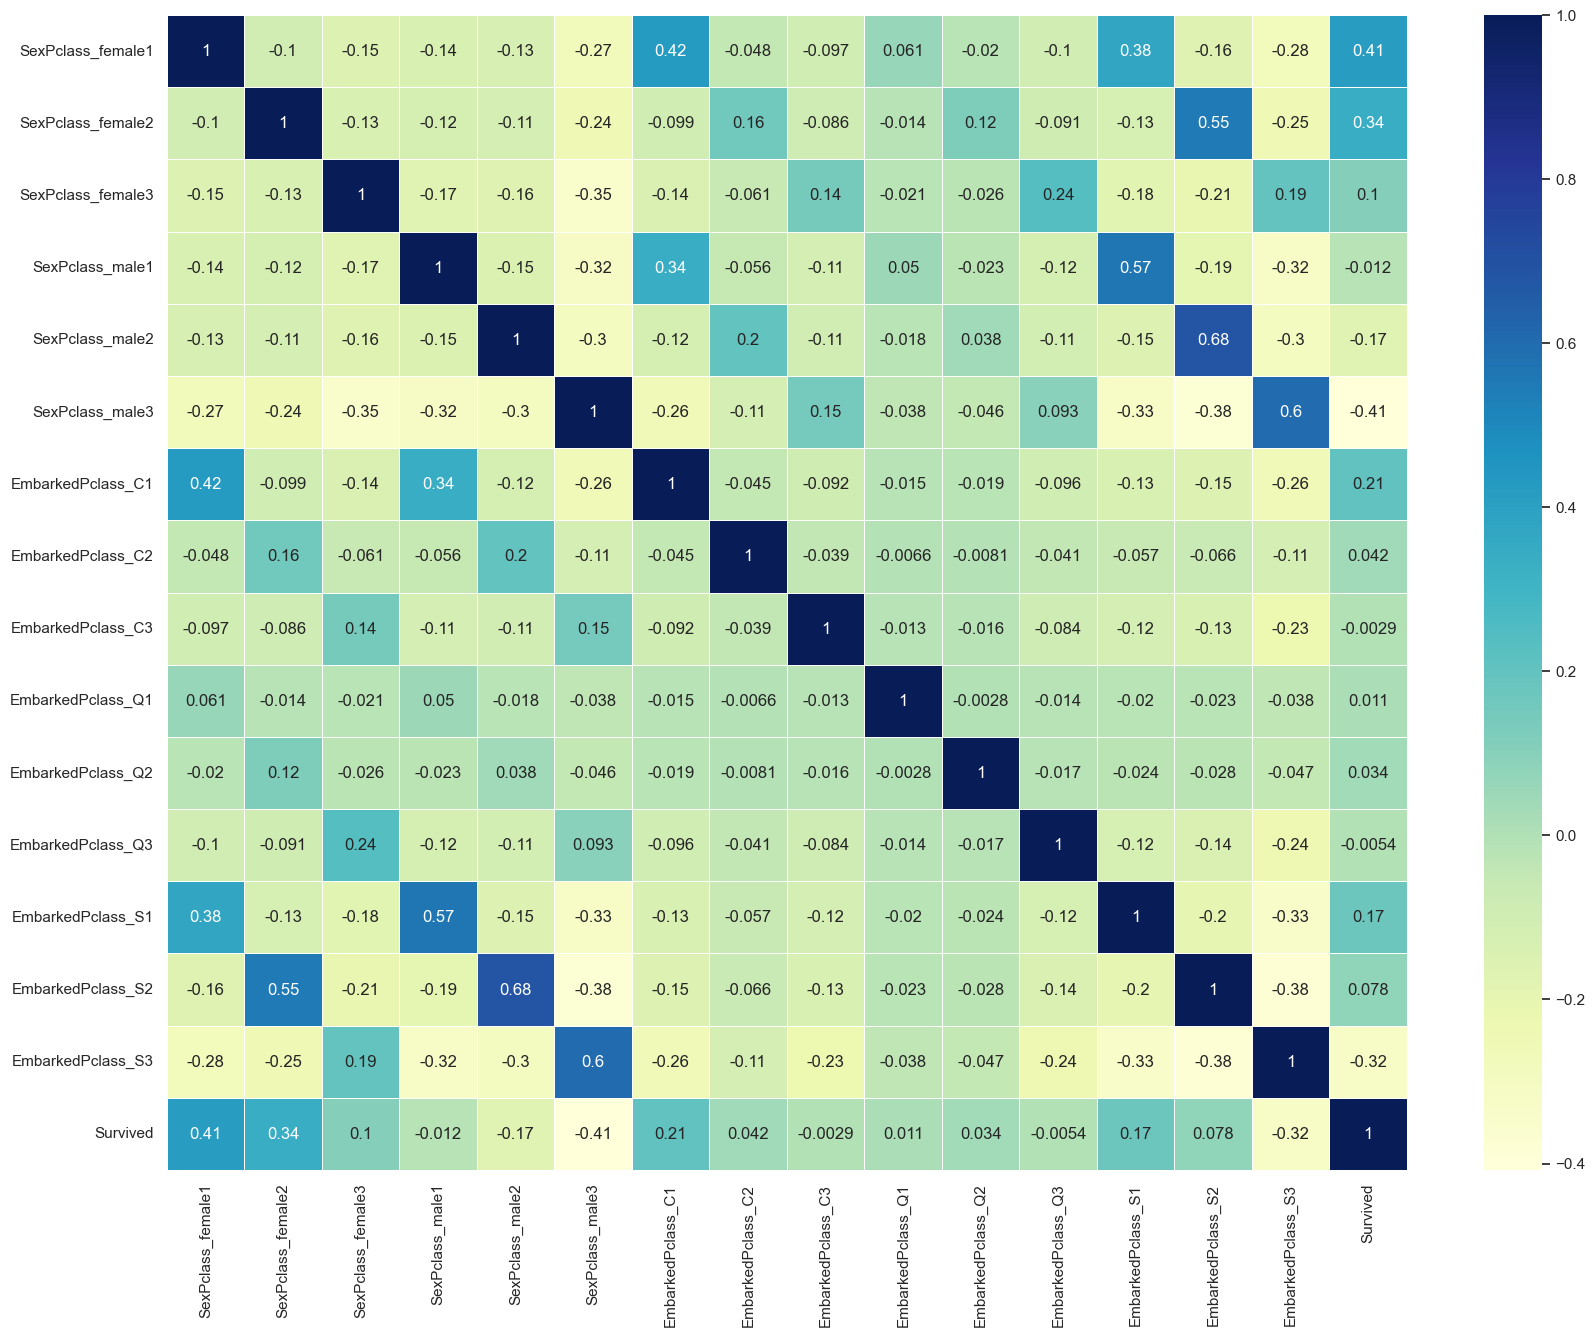

In [38]:
corr = temp_df.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True, linewidths=0.5, cmap='YlGnBu')

#### 상관관계도 분석

- 성별이 여자이면서 1등석에 탑승하면 생존 확률이 가장 높음
- 성별이 여자이지만 3등석에 탑승하면 생존 확률이 높지 않은 것을 확인할 수 있음

## ETC

- Feature끼리 더하기, 곱하기, 나누기 등등
- 왜 잘 되는지 모르는데 잘 되는 경우도 있음
- 도메인 지식과 EDA로 좋은 Feature들을 생성해보기